This phase is focused on simple analysis techniques - to get more info about the system.

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sensor.csv']


**1. Load and convert data types**

First load the data and convert timesetamps

In [26]:
df = pd.read_csv('../input/sensor.csv', engine='python', sep = ',', decimal = '.')
df['timestamp'] =  pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S' ,utc='True')
df.head()


,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00+00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00+00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00+00:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00+00:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00+00:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


**2. Preliminary investigation**

Check if the dt is equal

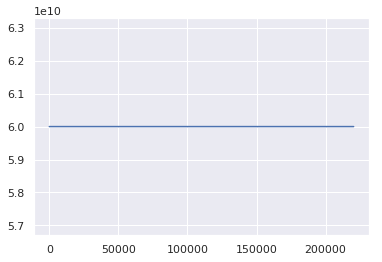

In [27]:
d = df['timestamp'].diff()
plt.plot(d[1:])

dt is equal - we can treat every column as evenly sampled series of data - wich simplifies analysis. We can drop Unnamed column with row numbers:


In [28]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

Now lets check NaNs:

In [29]:

print(df.shape)
nan_stats = df.isnull().sum().sort_values(ascending = False)/df.shape[0]
nan_stats

(220320, 54)


sensor_15         1.000000
sensor_50         0.349569
sensor_51         0.069821
sensor_00         0.046333
sensor_07         0.024741
sensor_08         0.023180
sensor_06         0.021777
sensor_09         0.020856
sensor_01         0.001675
sensor_30         0.001185
sensor_29         0.000327
sensor_32         0.000309
sensor_17         0.000209
sensor_18         0.000209
sensor_22         0.000186
sensor_25         0.000163
sensor_16         0.000141
sensor_43         0.000123
sensor_42         0.000123
sensor_49         0.000123
sensor_48         0.000123
sensor_47         0.000123
sensor_46         0.000123
sensor_38         0.000123
sensor_39         0.000123
sensor_45         0.000123
sensor_40         0.000123
sensor_41         0.000123
sensor_44         0.000123
sensor_14         0.000095
sensor_26         0.000091
sensor_11         0.000086
sensor_02         0.000086
sensor_03         0.000086
sensor_04         0.000086
sensor_05         0.000086
sensor_13         0.000086
s

Sensor 15 has no data - we can drop the column:

In [30]:
df.drop(['sensor_15'], axis=1, inplace=True)

We will also check the sensors that have more than 2% of nans - lets see it together with the machine status:

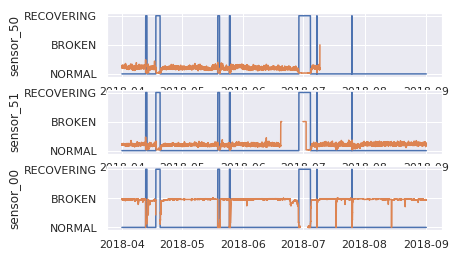

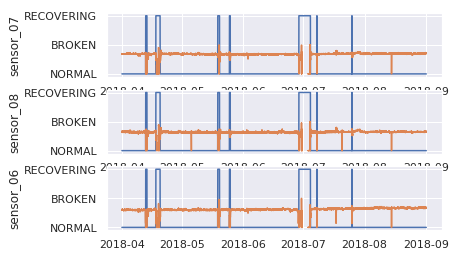

In [31]:
# plot in two windows with status - to asses nan's presence according to pump state.
# divide sesnro values by its max to get better scaling to status (actual values are not of our interest here)

fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.set_ylabel(nan_stats.index[1])
ax1.plot(df['timestamp'],df['machine_status'])
ax1.plot(df['timestamp'],df[nan_stats.index[1]]/max(df[nan_stats.index[1]]))
ax2.set_ylabel(nan_stats.index[2])
ax2.plot(df['timestamp'],df['machine_status'])
ax2.plot(df['timestamp'],df[nan_stats.index[2]]/max(df[nan_stats.index[2]]))
ax3.set_ylabel(nan_stats.index[3])
ax3.plot(df['timestamp'],df['machine_status'])
ax3.plot(df['timestamp'],df[nan_stats.index[3]]/max(df[nan_stats.index[3]]))
plt.show()


fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.set_ylabel(nan_stats.index[4])
ax1.plot(df['timestamp'],df['machine_status'])
ax1.plot(df['timestamp'],df[nan_stats.index[4]]/max(df[nan_stats.index[4]]))
ax2.set_ylabel(nan_stats.index[5])
ax2.plot(df['timestamp'],df['machine_status'])
ax2.plot(df['timestamp'],df[nan_stats.index[5]]/max(df[nan_stats.index[5]]))
ax3.set_ylabel(nan_stats.index[6])
ax3.plot(df['timestamp'],df['machine_status'])
ax3.plot(df['timestamp'],df[nan_stats.index[6]]/max(df[nan_stats.index[6]]))
plt.show()


We can see that:
* sensor 50 fails after 6th failure of the pump and its reading are not available until the end of our dataframe. Maybe its not crucial for system operation and its repair is not economicaly justified.
* Sensor 51 fails before 5th failure of the pump but during recovering from that failure gets back to normal operation
* Sensors 00, 07, 08, 06 - have significant period of nan's during recovering state after 5th failure of the pump, but we may assume that their data coverage for failure prediction is OK

From these plots we can also assume that 5th failure may correspond to different failure mode than the others - but we don't have any confirmation of that fact.

Lets remove also the sensor_50 - we don't have 1/3 of the data and to reproduce the missing ones - we would have to estimate nearly 2 months of readings:

In [32]:
df.drop(['sensor_50'], axis=1, inplace=True)

Initially there was 52 sensors, we removed the 15th and 50th. Now we have 50 sensors and we don't know what kind of sensors they are (temperature, flow, pressure, vibration, pump motor current?). Lets investigate data ranges etc:

In [33]:
# features extractor for columns
def get_column_features(df):
    
    df_features = pd.DataFrame()
    col_list = ['Col','Max','Min','q_0.25','q_0.50','q_0.75']
    
    for column in df:
        tmp_q = df[column].quantile([0.25,0.5,0.75])
        tmp1 = pd.Series([column,max(df[column]),min(df[column]),tmp_q[0.25],tmp_q[0.5],tmp_q[0.75]],name='d')
        tmp1.index = col_list
        df_features = df_features.append(tmp1)
        
    return df_features

# get list os signal columns without timestamp and status:
signal_columns = [c for c in df.columns if c not in ['timestamp', 'machine_status']]
get_column_features(df[signal_columns])

,Col,Max,Min,q_0.25,q_0.50,q_0.75
d,sensor_00,2.549016,0.000000,2.438831,2.456539,2.499826
d,sensor_01,56.727430,0.000000,46.310760,48.133678,49.479160
d,sensor_02,56.032990,33.159720,50.390620,51.649300,52.777770
d,sensor_03,48.220490,31.640620,42.838539,44.227428,45.312500
d,sensor_04,800.000000,2.798032,626.620400,632.638916,637.615723
d,sensor_05,99.999880,0.000000,69.976260,75.576790,80.912150
d,sensor_06,22.251160,0.014468,13.346350,13.642940,14.539930
d,sensor_07,23.596640,0.000000,15.907120,16.167530,16.427950
d,sensor_08,24.348960,0.028935,15.183740,15.494790,15.697340
d,sensor_09,25.000000,0.000000,15.053530,15.082470,15.118630


By these features we can see, that:
* all these sensors are analog sensors (no relays with only 0 and 1 values, binary switches etc). All of them have positive values.
* we can also see that some of the sensors have max values expressed as whole numbers. For analog sensors - it can be symptom of reading truncated at scale end. We remember sensors 50 and 51 from nan's investigation - and by going by to plots we can see that nan's periods (failures of these sensors?) are preceded by achieving value of 1000 (saturated sensor/electrical problems/ loose cable connection?)

We will have all of that in mind during further investigation


**3. Correlation check**

Now lets check if some of the sensors are correlated:

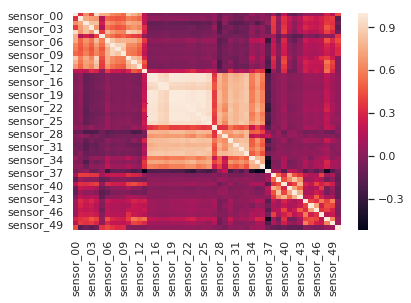

In [34]:
corr = df[signal_columns].corr()
sns.heatmap(corr)

We can see strongly correlated group of sensors - from sensor_14 to sensor_26.
There also some other correlated groups but not as strong as the mentioned one.


**4. Failure data investigation**

Lets locate the failure events:

In [35]:
#locate indices of failure events and recovering and normal state
normal_idx = df.loc[df['machine_status'] == 'NORMAL'].index
failure_idx = df.loc[df['machine_status'] == 'BROKEN'].index
recovering_idx = df.loc[df['machine_status'] == 'RECOVERING'].index

bef_failure_idx = list()
for j in failure_idx:
    for i in range(24*60):
        bef_failure_idx.append(j-i)

bef_failure_idx.sort()

#locate timestamps of failures:
failures_timestamps = df.loc[failure_idx,'timestamp']
print(failures_timestamps)

17155    2018-04-12 21:55:00+00:00
24510    2018-04-18 00:30:00+00:00
69318    2018-05-19 03:18:00+00:00
77790    2018-05-25 00:30:00+00:00
128040   2018-06-28 22:00:00+00:00
141131   2018-07-08 00:11:00+00:00
166440   2018-07-25 14:00:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]


We can see that first 6 failures happened during late evening/night - only 7th was at 14pm.
Lets check the sensors behaviour before the failure and during the recovering state:

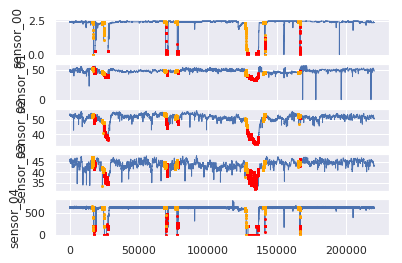

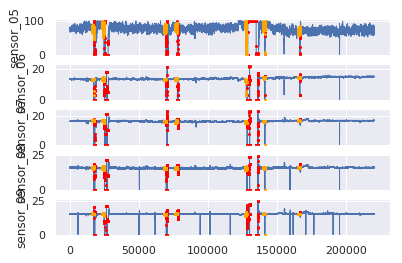

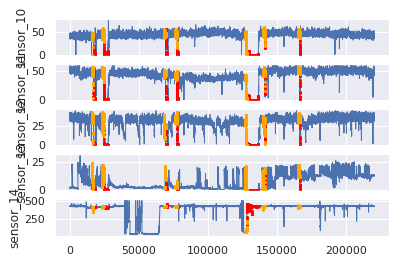

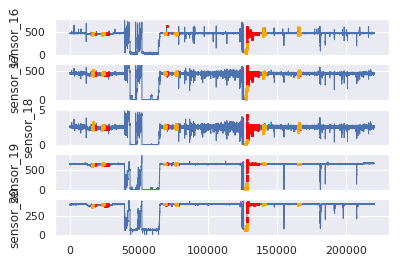

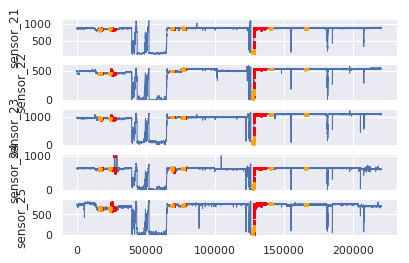

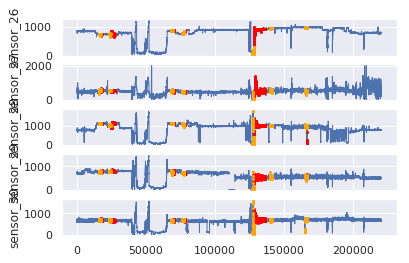

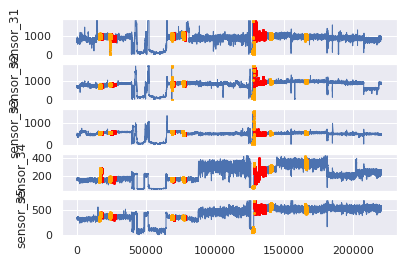

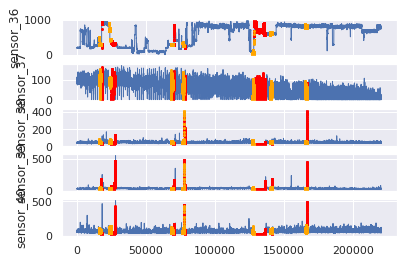

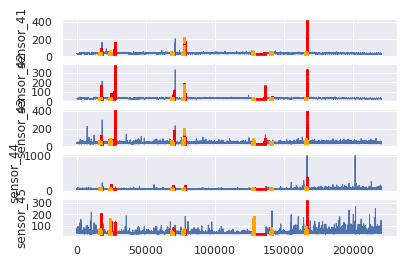

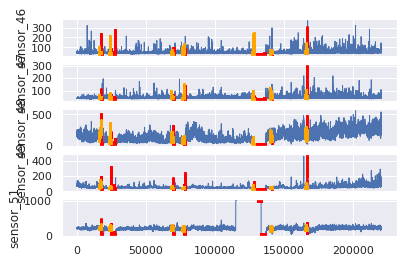

In [36]:
for i in range(10):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1)
    
    ax1.set_ylabel(signal_columns[i*5])
    ax1.plot(df[signal_columns[i*5]],linewidth=1)
    ax1.plot(df.loc[list(recovering_idx),signal_columns[i*5]],linestyle='none',marker='.',color='red',markersize=4)
    ax1.plot(df.loc[bef_failure_idx,signal_columns[i*5]],linestyle='none',marker='.',color='orange',markersize=4)
        
    ax2.set_ylabel(signal_columns[i*5+1])
    ax2.plot(df[signal_columns[i*5+1]],linewidth=1)
    ax2.plot(df.loc[list(recovering_idx),signal_columns[i*5+1]],linestyle='none',marker='.',color='red',markersize=4)
    ax2.plot(df.loc[bef_failure_idx,signal_columns[i*5+1]],linestyle='none',marker='.',color='orange',markersize=4)
    
    ax3.set_ylabel(signal_columns[i*5+2])
    ax3.plot(df[signal_columns[i*5+2]],linewidth=1)
    ax3.plot(df.loc[list(recovering_idx),signal_columns[i*5+2]],linestyle='none',marker='.',color='red',markersize=4)
    ax3.plot(df.loc[bef_failure_idx,signal_columns[i*5+2]],linestyle='none',marker='.',color='orange',markersize=4)
    
    ax4.set_ylabel(signal_columns[i*5+3])
    ax4.plot(df[signal_columns[i*5+3]],linewidth=1)
    ax4.plot(df.loc[list(recovering_idx),signal_columns[i*5+3]],linestyle='none',marker='.',color='red',markersize=4)
    ax4.plot(df.loc[bef_failure_idx,signal_columns[i*5+3]],linestyle='none',marker='.',color='orange',markersize=4)
    
    ax5.set_ylabel(signal_columns[i*5+4])
    ax5.plot(df[signal_columns[i*5+4]],linewidth=1)
    ax5.plot(df.loc[list(recovering_idx),signal_columns[i*5+4]],linestyle='none',marker='.',color='red',markersize=4)
    ax5.plot(df.loc[bef_failure_idx,signal_columns[i*5+4]],linestyle='none',marker='.',color='orange',markersize=4)
    plt.show()



First findings:
* sensor 37 has diminishing trend and its behaviour its a bit odd. Also has saturated readings on the botton of the scale

to be continued - but before digging into real datascience and ML stuff some info about the system/failure modes/repair& maintenance policies/constraints would be helpful